In [2]:
#Importing Libaries
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

import matplotlib
import seaborn as sns


In [3]:
#Importing data and describe it
df = pd.read_csv("data/Gross_Revenue.csv", delimiter=";", decimal=",")
df.columns = ['year','Gross_Revenue']
df.head(3)
df.describe()

,Gross_Revenue
count,93.000000
mean,3707.365591
std,1329.275602
min,1917.000000
25%,2534.000000
50%,3493.000000
75%,4680.000000
max,7278.000000


In [4]:
print('Time period start: {}\nTime period end: {}'.format(df.year.min(),df.year.max()))

Time period start: 2015-01
Time period end: 2022-09


In [5]:
df.columns

Index(['year', 'Gross_Revenue'], dtype='object')

In [6]:
#Converting to datetime format:
df['year'] = pd.to_datetime(df['year'], format='%Y-%m')

In [7]:
#Setting index as the datetime column for easier manipulations: 
y = df.set_index('year')
y.index 

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
     

In [8]:
y.isnull().sum()

Gross_Revenue    0
dtype: int64

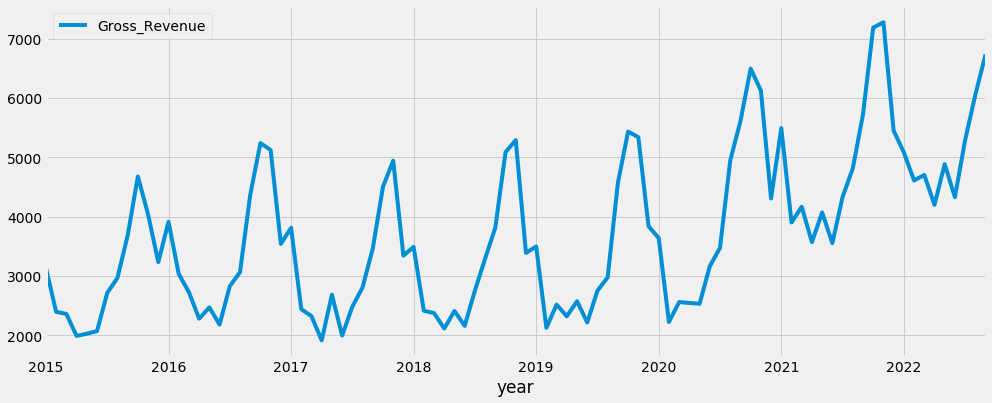

In [9]:
#Visualize the data imported
y.plot(figsize=(15, 6))
plt.show()

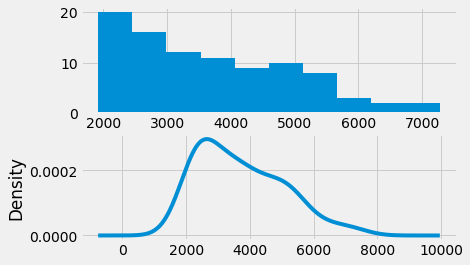

In [10]:
#Reviewing plots of the density of observations can provide further insight into the structure of the data: 
#The distribution is is illustrated whether it is normal distributed
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.Gross_Revenue.hist()
pyplot.subplot(212)
y.Gross_Revenue.plot(kind='kde')
pyplot.show()

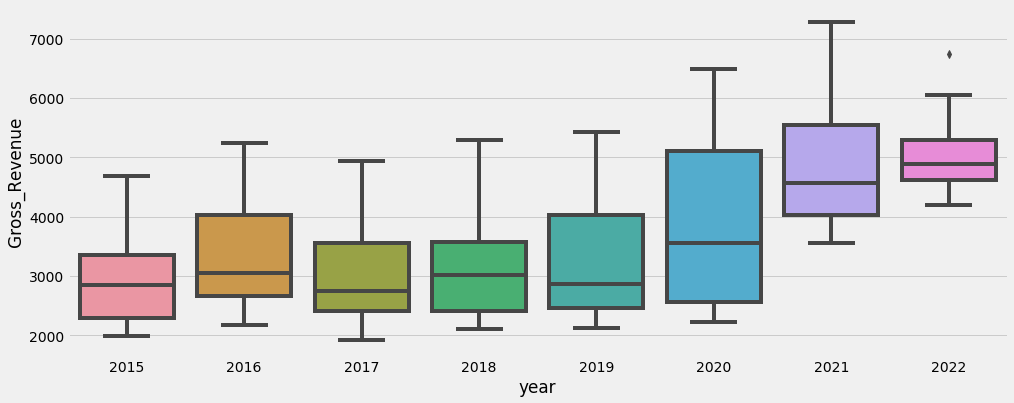

In [11]:
#Box and Whiskers Plots
#Median values across years confirms and upwards trend

fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(y.Gross_Revenue.index.year, y.Gross_Revenue, ax=ax)

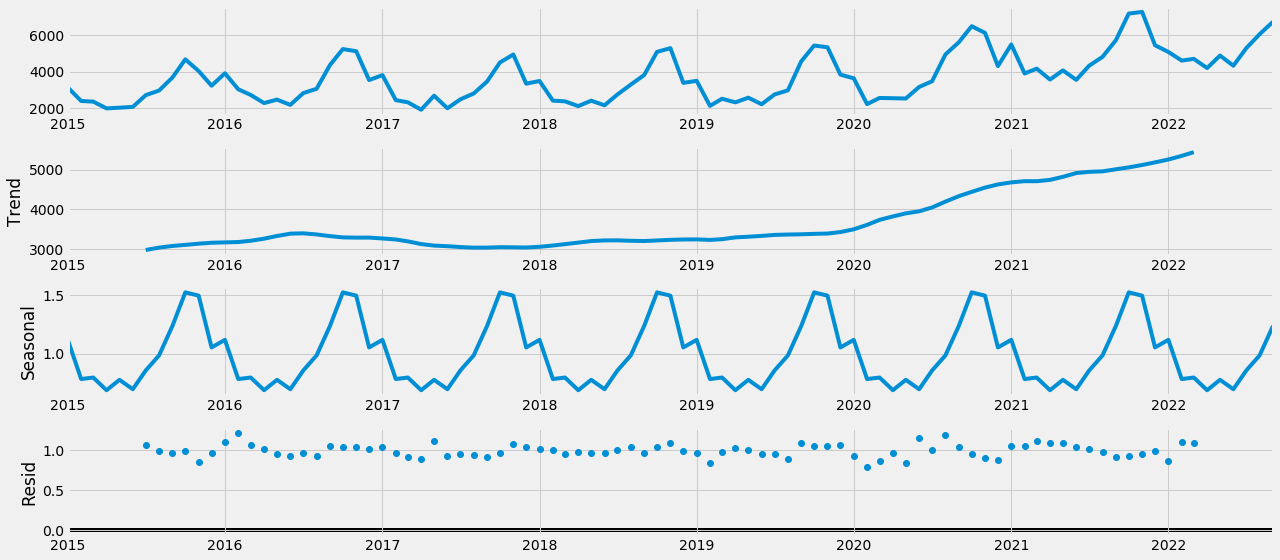

In [12]:
#Decomposing using statsmodel
#The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories patterns. 
#With statsmodels it is able to see the trend, seasonal, and residual components of the data. 
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()


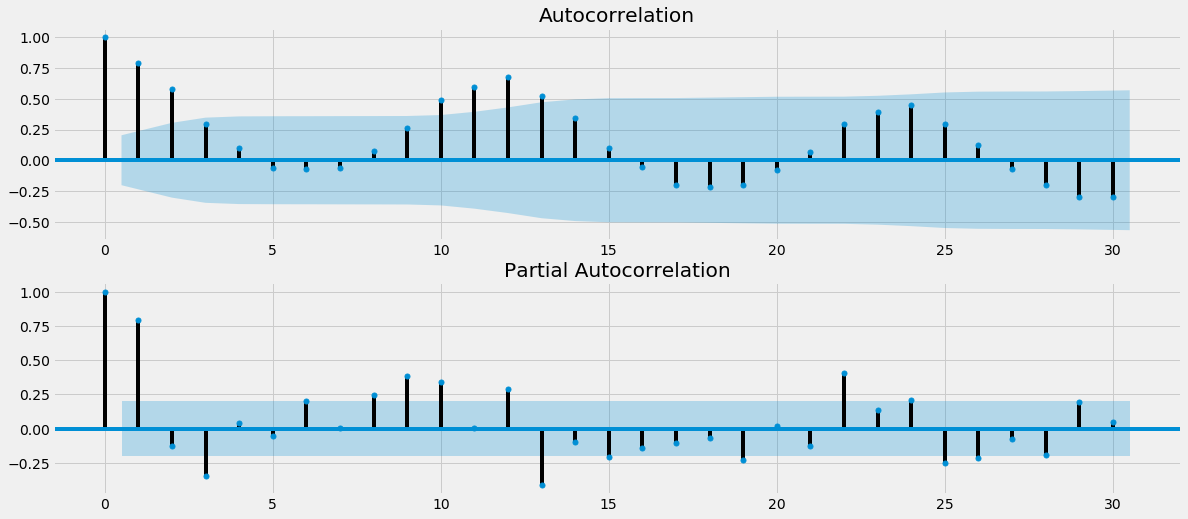

In [13]:
#Stationarity 
#A time series is said to be stationary if its statistical properties such as mean and variance remain cosntant over time. 
#Most of the Time Series models work on the assumption that the TS is stationary. Major reason for this is that there are many ways in which a series can be non-stationary, but only one way for stationarity.
#Intuitively, we can say that if a Time Series has a particular behaviour over time, there is a very high probability that it will follow the same in the future.

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y.Gross_Revenue, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(y.Gross_Revenue, ax=pyplot.gca(), lags = 30)
pyplot.show()

#ACF and PACF plots: If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.
#Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. Moving average/variance is for any instant ‘t’, the average/variance of the last year, i.e. last 12 months.
#Augmented Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.


In [14]:
#Augmented Dickey-Fuller Test & Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y.Gross_Revenue, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)


Results of Dickey-Fuller Test:
Test Statistic                  1.890299
p-value                         0.998512
#Lags Used                     12.000000
Number of Observations Used    80.000000
Critical Value (1%)            -3.514869
Critical Value (5%)            -2.898409
Critical Value (10%)           -2.586439
dtype: float64


In [15]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [16]:
#ARIMA 
#In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

#Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
#Number of Differences (d): d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
#Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.


ts = y.Gross_Revenue - y.Gross_Revenue.shift()
ts.dropna(inplace=True)

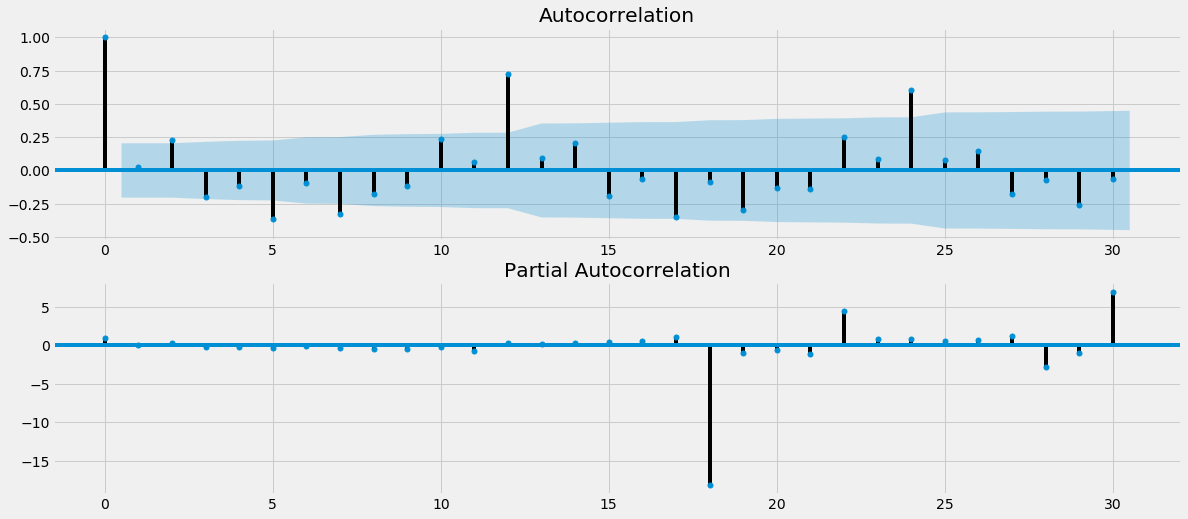

In [17]:
#ACF and PACF plots after differencing:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca(),lags=30)
pyplot.subplot(212)
plot_pacf(ts, ax=pyplot.gca(),lags=30)
pyplot.show()

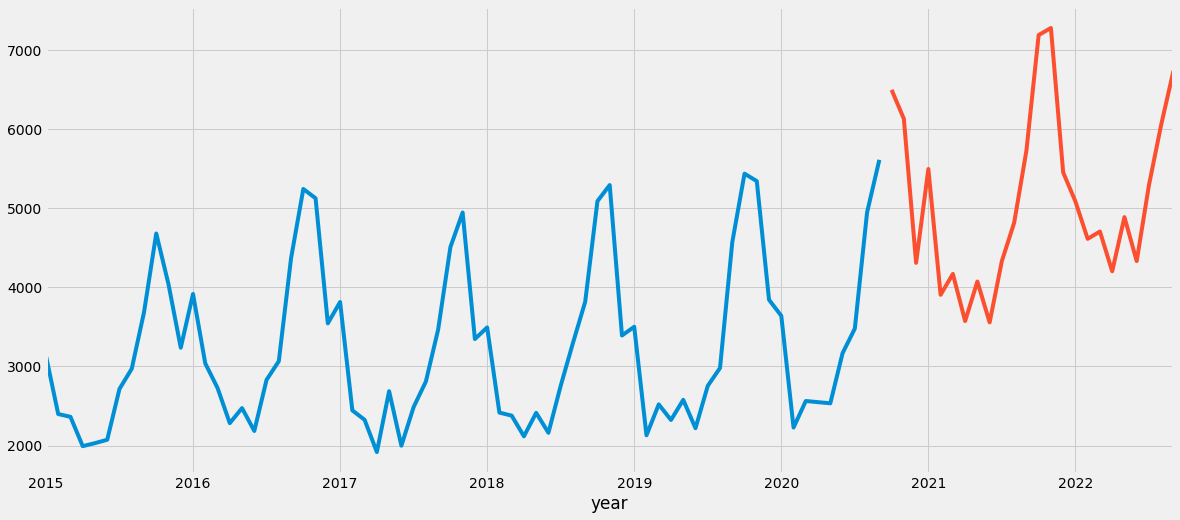

In [18]:
#divide into train and validation set
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]

#plotting the data
train['Gross_Revenue'].plot()
valid['Gross_Revenue'].plot()

In [19]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit(disp=1)

c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [20]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D.Gross_Revenue   No. Observations:                   68
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -547.267
Method:                       css-mle   S.D. of innovations            756.719
Date:                Mon, 24 Oct 2022   AIC                           1102.535
Time:                        12:09:32   BIC                           1111.413
Sample:                    02-01-2015   HQIC                          1106.052
                         - 09-01-2020                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    36.9703    108.412      0.341      0.733    -175.512     249.453
ar.L1.D.Gross_Revenue     0.3893      0.330      1.180      0.238      -0.257       1.036
ma.L1.D.Gross_Revenue    -0.2758      0.324     -0.850      0.395      -0.912       0.360
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5690           +0.0000j            2.5690            0.0000
MA.1            3.6252           +0.0000j            3.6252            0.0000
-----------------------------------------------------------------------------
"""

In [21]:
#SARIMA Modeling
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [22]:
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1300.2546701896456

c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, Value

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1075.7719843461148
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:857.1240522892215
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:673.2077436715517


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:869.2118220767578
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:854.562070168068
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:687.0090274936554
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:674.2524496551451
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1240.3603078769238


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Convergence

ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1008.9352363631047
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:826.3491977226747
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:646.5378402232716


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:855.4165823818167


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:826.6287687752337
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:674.4837599226918


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:647.5922970838106
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1081.6368377702274
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:859.5768973304063
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:821.8926279348381

c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)



ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:640.0055399179283


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:836.4607292938941
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:820.8966139799603
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:656.1905794897033


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:641.6359051485737
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1068.1673729336842
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:847.7088977043687

c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)



ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:801.7293784875586


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:620.281274117575
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:832.4525245742525


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:800.4252497350282
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:652.301322070645

c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:621.772526097879
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1099.5017648466167


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Convergence

ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:913.6895481225906
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:828.1400982162728
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:652.7766925508297
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:829.7503678243452


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:827.9901009441301
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:652.6837131412268


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:654.3707197567318
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1085.1433456180664


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Convergence

ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:899.6020264852178
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:814.9721722130013
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:636.2836395344241


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:830.3041387336417


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:814.9733155145174


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:654.087569731659


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:638.1429311783043
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1083.1028265966215


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:861.5765254858076
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:815.1333607352979


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:634.3056013862202
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:817.1094436276938


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:816.3312051419215
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:634.3631035054304


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:636.1828089813877
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1064.2094167639002


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:842.6975955381757
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:801.2357218991309


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:622.2526516633494


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:818.8880649918913


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:802.056332603526


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:635.937824356394


c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:623.7715516674409


In [23]:
min_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      Gross_Revenue   No. Observations:                   69
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -307.141
Date:                            Mon, 24 Oct 2022   AIC                            620.281
Time:                                    12:09:46   BIC                            625.494
Sample:                                01-01-2015   HQIC                           622.192
                                     - 09-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4666      0.164     -2.847      0.004      -0.788      -0.145
ma.S.L12      -0.3269      0.261     -1.253      0.210      -0.838       0.184
sigma2      1.312e+05   2.12e+04      6.182      0.000    8.96e+04    1.73e+05
===================================================================================
Ljung-Box (Q):                       47.39   Jarque-Bera (JB):                17.55
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               2.69   Skew:                             1.30
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
#Period for forecast
start_analysis = "2015-01-01"
end_analysis = "2025-12-31"

#Predictions
pred = min_aic_model.get_prediction(start=start_analysis,end=end_analysis, dynamic=False)

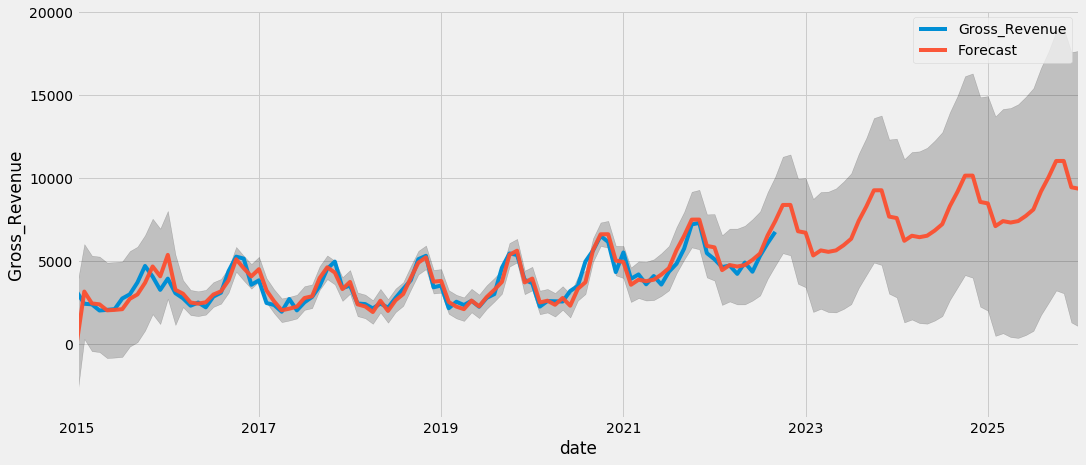

2015-01-01        0.000000
2015-02-01     3136.000000
2015-03-01     2419.201497
2015-04-01     2364.594516
2015-05-01     2002.570928
                  ...     
2025-09-01    10038.065772
2025-10-01    11015.734038
2025-11-01    11019.451416
2025-12-01     9429.233145
2026-01-01     9341.902467
Freq: MS, Length: 133, dtype: float64
            lower Gross_Revenue  upper Gross_Revenue
2015-01-01         -3394.757202          3394.757202
2015-02-01           274.710198          5997.289802
2015-03-01          -460.028835          5298.431829
2015-04-01          -514.650393          5243.839425
2015-05-01          -876.673993          4881.815848
...                         ...                  ...
2025-09-01          2453.243470         17622.888074
2025-10-01          3202.333330         18829.134746
2025-11-01          3033.086796         19005.816036
2025-12-01          1273.571992         17584.894298
2026-01-01          1020.388271         17663.416664

[133 rows x 2 columns]


In [25]:
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.95, figsize=(16, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('date')
ax.set_ylabel('Gross_Revenue')
plt.legend()
plt.show()

print(pred.predicted_mean)
print(pred_ci)

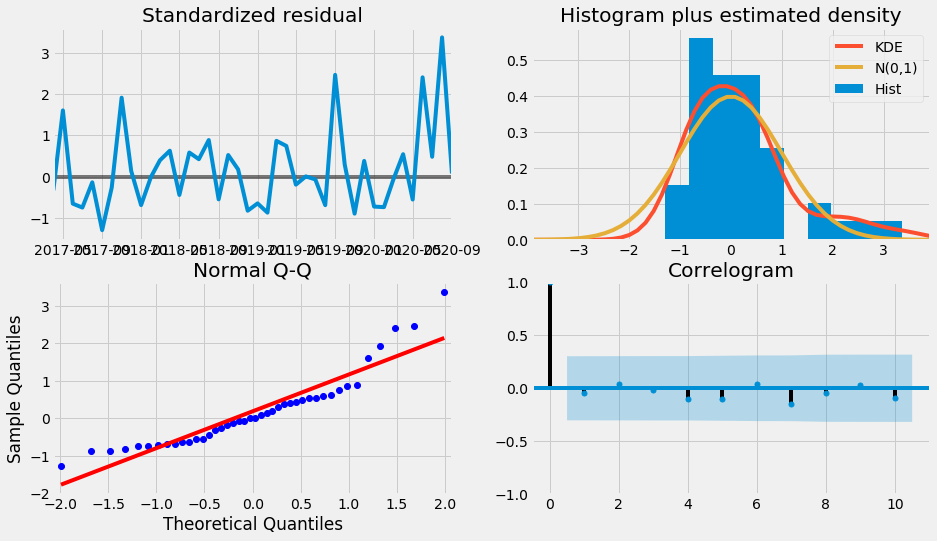

In [26]:
results.plot_diagnostics(figsize=(14, 8))
plt.show()

In [27]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [28]:
#Evaluate Forecast
y_forecasted = pred.predicted_mean.values
y_truth = y[start_analysis:end_analysis].revenue.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

AttributeError: 'DataFrame' object has no attribute 'revenue'

In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 224.59


In [ ]:
evaluate_forecast(y_truth, y_forecasted)

NameError: name 'y_truth' is not defined